In [26]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics

# import tikzplotlib

In [27]:
from notebook_utils import *

In [28]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets

In [29]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..


In [30]:
len(cc_test_datasets_multiclass)

30

In [31]:
def get_datasets(selector, task_type, suite='openml'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
            # print(f"cc_test_datasets_multiclass is used")
        else:
            raise Exception("Unknown suite")
    return ds

# Setting params

In [32]:
eval_positions = [1000]
max_features = 100
bptt = 2000
selector = 'test'
base_path = os.path.join('.')
overwrite=False
# max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
max_times = [0.5]
metric_used = tabular_metrics.auc_metric
# methods = ['transformer', 'logistic', 'gp', 'knn', 'catboost', 'xgb', 'autosklearn2', 'autogluon']
methods = ['transformer','logistic']
task_type = 'multiclass'

In [33]:
suite = 'cc'
test_datasets = get_datasets('test',task_type, suite=suite)

In [34]:
clf_dict= {
               'gp': gp_metric 
               , 'knn': knn_metric
               , 'catboost': catboost_metric
               , 'xgb': xgb_metric
               , 'transformer': transformer_metric # our model (1) - trained 1h
               , 'i_transformer': transformer_metric # our model (2) - trained 12h
               , 'tab_transformer': transformer_metric # original TabPFN - trained 10h
               , 'logistic': logistic_metric
               , 'autosklearn': autosklearn_metric
               , 'autosklearn2': autosklearn2_metric
               , 'autogluon': autogluon_metric
                }

In [35]:
device = 'cpu'

def eval_method(task_type, method, dids, selector, eval_positions, max_time, metric_used, split_number, append_metric=True, fetch_only=False, verbose=False):
    
    dids = dids if type(dids) is list else [dids]
    
    # print(f"dids {dids}")
    
    for did in dids:

        ds = get_datasets(selector, task_type, suite=suite)

        ds = ds if did is None else ds[did:did+1]

        clf = clf_dict[method]

        time_string = '_time_'+str(max_time) if max_time else ''
        metric_used_string = '_'+tabular_baselines.get_scoring_string(metric_used, usage='') if append_metric else ''

        result = evaluate(datasets=ds
                          , model=clf
                          , method=method+time_string+metric_used_string
                          , bptt=bptt, base_path=base_path
                          , eval_positions=eval_positions
                          , device=device, max_splits=1
                          , overwrite=overwrite
                          , save=True
                          , metric_used=metric_used
                          , path_interfix=task_type
                          , fetch_only=fetch_only
                          , split_number=split_number
                          , verbose=verbose
                          , max_time=max_time)
    
    return result

# Baseline Evaluation
This section runs baselines and saves results locally.

In [11]:
%%script echo skipping

!mkdir {base_path}/results
!mkdir {base_path}/results/tabular/
!mkdir {base_path}/results/tabular/multiclass/

skipping


In [11]:
# %%script echo skipping

# RUN ONE METHOD ON ONE DATASET AND SPLIT
overwrite=True
dataset_id = 0
split_number = 1
maximum_runtime = 1
# r = eval_method(task_type, 'transformer', dataset_id, 'test', eval_positions, maximum_runtime, metric_used, split_number)
r = eval_method(task_type, 'tab_transformer', dataset_id, 'test', eval_positions, maximum_runtime, metric_used, split_number)

# in tabular_baselines.py, function transformer_metric():
# we have to specify model_string='_Single_layer_', epoch = 39
# for a file prior_diff_real_checkpoint_Single_layer__n_0_epoch_39.cpkt

# i_transformer:
# prior_diff_real_checkpoint_Euler_2_layer_t2_n_1_epoch_9.cpkt

# tab_transformer:
# prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt

Calculating splits<function transformer_metric at 0x7f9aac1c37b8> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7f9aac1c37b8> 312:   0%|          | 0/1 [00:01<?, ?it/s]

saved results to ./results/tabular/multiclass/results_tab_transformer_time_1_roc_auc_balance-scale_312_624_1.npy



/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [37]:
# %%script echo skipping

# RUN ALL METHODS, SPLITS AND DATASETS
test_datasets = get_datasets('test',task_type, suite=suite)

methods = ['tab_transformer']
max_times = [5]

overwrite=True
jobs = [
    eval_method(task_type, m, did, selector, eval_positions, max_time, metric_used, split_number)
    for did in range(0, len(test_datasets))
    for selector in ['test']
    for m in methods
    for max_time in max_times # max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
    for split_number in [1, 2, 3, 4, 5]
]

/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_balance-scale_312_624_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_balance-scale_312_624_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_balance-scale_312_624_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_balance-scale_312_624_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([312, 4])  Test data shape torch.Size([312, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_balance-scale_312_624_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-fourier_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-fourier_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-fourier_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-fourier_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 76])  Test data shape torch.Size([1000, 76])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-fourier_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_breast-w_349_698_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_breast-w_349_698_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_breast-w_349_698_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_breast-w_349_698_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([349, 9])  Test data shape torch.Size([349, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 349:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_breast-w_349_698_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-karhunen_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-karhunen_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-karhunen_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-karhunen_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 64])  Test data shape torch.Size([1000, 64])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-karhunen_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-morphological_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-morphological_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-morphological_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-morphological_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 6])  Test data shape torch.Size([1000, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-morphological_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-zernike_1000_2000_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-zernike_1000_2000_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-zernike_1000_2000_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-zernike_1000_2000_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([1000, 47])  Test data shape torch.Size([1000, 47])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 1000:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_mfeat-zernike_1000_2000_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cmc_736_1472_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cmc_736_1472_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cmc_736_1472_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cmc_736_1472_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([736, 9])  Test data shape torch.Size([736, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 736:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cmc_736_1472_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-approval_345_690_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-approval_345_690_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-approval_345_690_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-approval_345_690_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([345, 15])  Test data shape torch.Size([345, 15])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 345:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-approval_345_690_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-g_500_1000_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-g_500_1000_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-g_500_1000_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-g_500_1000_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([500, 20])  Test data shape torch.Size([500, 20])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 500:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_credit-g_500_1000_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_diabetes_384_768_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_diabetes_384_768_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_diabetes_384_768_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_diabetes_384_768_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([384, 8])  Test data shape torch.Size([384, 8])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 384:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_diabetes_384_768_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_tic-tac-toe_479_958_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_tic-tac-toe_479_958_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_tic-tac-toe_479_958_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_tic-tac-toe_479_958_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([479, 9])  Test data shape torch.Size([479, 9])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 479:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_tic-tac-toe_479_958_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_vehicle_423_846_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_vehicle_423_846_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_vehicle_423_846_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_vehicle_423_846_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([423, 18])  Test data shape torch.Size([423, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 423:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_vehicle_423_846_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_eucalyptus_368_736_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_eucalyptus_368_736_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_eucalyptus_368_736_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_eucalyptus_368_736_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([368, 19])  Test data shape torch.Size([368, 19])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 368:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_eucalyptus_368_736_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_authorship_420_840_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_authorship_420_840_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_authorship_420_840_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_authorship_420_840_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([420, 70])  Test data shape torch.Size([420, 70])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 420:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_authorship_420_840_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_dmft_398_796_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_dmft_398_796_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_dmft_398_796_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_dmft_398_796_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([398, 4])  Test data shape torch.Size([398, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 398:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_analcatdata_dmft_398_796_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc4_729_1458_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc4_729_1458_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc4_729_1458_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc4_729_1458_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([729, 37])  Test data shape torch.Size([729, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 729:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc4_729_1458_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc3_781_1562_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc3_781_1562_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc3_781_1562_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc3_781_1562_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([781, 37])  Test data shape torch.Size([781, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 781:   0%|          | 0/1 [00:04<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc3_781_1562_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_kc2_261_522_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_kc2_261_522_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_kc2_261_522_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_kc2_261_522_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([261, 21])  Test data shape torch.Size([261, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 261:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_kc2_261_522_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc1_554_1108_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc1_554_1108_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc1_554_1108_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc1_554_1108_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([554, 21])  Test data shape torch.Size([554, 21])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 554:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_pc1_554_1108_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_banknote-authentication_686_1372_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_banknote-authentication_686_1372_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_banknote-authentication_686_1372_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_banknote-authentication_686_1372_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([686, 4])  Test data shape torch.Size([686, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 686:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_banknote-authentication_686_1372_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_blood-transfusion-service-center_374_748_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_blood-transfusion-service-center_374_748_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_blood-transfusion-service-center_374_748_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_blood-transfusion-service-center_374_748_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([374, 4])  Test data shape torch.Size([374, 4])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 374:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_blood-transfusion-service-center_374_748_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_ilpd_291_582_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_ilpd_291_582_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_ilpd_291_582_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_ilpd_291_582_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([291, 10])  Test data shape torch.Size([291, 10])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 291:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_ilpd_291_582_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_qsar-biodeg_527_1054_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_qsar-biodeg_527_1054_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_qsar-biodeg_527_1054_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_qsar-biodeg_527_1054_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([527, 41])  Test data shape torch.Size([527, 41])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 527:   0%|          | 0/1 [00:02<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_qsar-biodeg_527_1054_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_wdbc_284_568_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_wdbc_284_568_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_wdbc_284_568_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_wdbc_284_568_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([284, 30])  Test data shape torch.Size([284, 30])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 284:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_wdbc_284_568_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cylinder-bands_270_540_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cylinder-bands_270_540_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cylinder-bands_270_540_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cylinder-bands_270_540_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 37])  Test data shape torch.Size([270, 37])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_cylinder-bands_270_540_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_dresses-sales_250_500_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_dresses-sales_250_500_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_dresses-sales_250_500_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_dresses-sales_250_500_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([250, 12])  Test data shape torch.Size([250, 12])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 250:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_dresses-sales_250_500_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_MiceProtein_540_1080_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_MiceProtein_540_1080_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_MiceProtein_540_1080_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_MiceProtein_540_1080_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([540, 77])  Test data shape torch.Size([540, 77])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 540:   0%|          | 0/1 [00:03<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_MiceProtein_540_1080_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:05<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_car_864_1728_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:05<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_car_864_1728_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:05<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_car_864_1728_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:05<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_car_864_1728_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([864, 6])  Test data shape torch.Size([864, 6])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 864:   0%|          | 0/1 [00:05<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_car_864_1728_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_steel-plates-fault_970_1940_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_steel-plates-fault_970_1940_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_steel-plates-fault_970_1940_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_steel-plates-fault_970_1940_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([970, 27])  Test data shape torch.Size([970, 27])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 970:   0%|          | 0/1 [00:06<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_steel-plates-fault_970_1940_5.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_climate-model-simulation-crashes_270_540_1.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_climate-model-simulation-crashes_270_540_2.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_climate-model-simulation-crashes_270_540_3.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_climate-model-simulation-crashes_270_540_4.npy


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:00<?, ?it/s]

Loading models_diff/prior_diff_real_checkpoint_Euler_Original_n_0_epoch_15.cpkt
Loading model that can be used for inference only
Using a Transformer with 13.21 M parameters
Train data shape torch.Size([270, 18])  Test data shape torch.Size([270, 18])


Calculating splits<function transformer_metric at 0x7f9a28242a60> 270:   0%|          | 0/1 [00:01<?, ?it/s]

saved results to ./results/tabular/multiclass/results_tab_transformer_time_5_roc_auc_climate-model-simulation-crashes_270_540_5.npy



/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [98]:
test_datasets = get_datasets('test',task_type, suite=suite)
len(test_datasets)

30

# Comparison

In [157]:
# %%script echo skipping

pos = str(eval_positions[0])

global_results = {}
overwrite=False

# print(methods)
# print(max_times)
# print(range(1,5+1))

methods = ['i_transformer','transformer','logistic']

# for method in baseline_methods:
for method in methods:
    for max_time in max_times:
        for split_number in range(1,5+1):
            global_results[method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)] = eval_method(task_type, method,  None, selector, 
                                                                                                                                    eval_positions, fetch_only=True, 
                                                                                                                                    verbose=False, max_time=max_time,
                                                                                                                                    metric_used=metric_used, split_number=split_number)

In [158]:
print(len(global_results)) # 10
# print(global_results.keys()) # dict_keys(['transformer_time_0.5roc_auc_split_1', 'transformer_time_0.5roc_auc_split_2', 'transformer_time_0.5roc_auc_split_3', 'transformer_time_0.5roc_auc_split_4', 'transformer_time_0.5roc_auc_split_5', 'logistic_time_0.5roc_auc_split_1', 'logistic_time_0.5roc_auc_split_2', 'logistic_time_0.5roc_auc_split_3', 'logistic_time_0.5roc_auc_split_4', 'logistic_time_0.5roc_auc_split_5'])

# print(len(global_results['transformer_time_0.5roc_auc_split_1'])) # 124
# print(global_results['transformer_time_0.5roc_auc_split_1'].keys()) # dict_keys(['metric_used', 'bptt', 'eval_positions', 'balance-scale_best_configs_at_1000', 'balance-scale_outputs_at_1000', 'balance-scale_ys_at_1000', 'balance-scale_time_at_1000', 'mfeat-fourier_best_configs_at_1000', 'mfeat-fourier_outputs_at_1000', 'mfeat-fourier_ys_at_1000', 'mfeat-fourier_time_at_1000', 'breast-w_best_configs_at_1000', 'breast-w_outputs_at_1000', 'breast-w_ys_at_1000', 'breast-w_time_at_1000', 'mfeat-karhunen_best_configs_at_1000', 'mfeat-karhunen_outputs_at_1000', 'mfeat-karhunen_ys_at_1000', 'mfeat-karhunen_time_at_1000', 'mfeat-morphological_best_configs_at_1000', 'mfeat-morphological_outputs_at_1000', 'mfeat-morphological_ys_at_1000', 'mfeat-morphological_time_at_1000', 'mfeat-zernike_best_configs_at_1000', 'mfeat-zernike_outputs_at_1000', 'mfeat-zernike_ys_at_1000', 'mfeat-zernike_time_at_1000', 'cmc_best_configs_at_1000', 'cmc_outputs_at_1000', 'cmc_ys_at_1000', 'cmc_time_at_1000', 'credit-approval_best_configs_at_1000', 'credit-approval_outputs_at_1000', 'credit-approval_ys_at_1000', 'credit-approval_time_at_1000', 'credit-g_best_configs_at_1000', 'credit-g_outputs_at_1000', 'credit-g_ys_at_1000', 'credit-g_time_at_1000', 'diabetes_best_configs_at_1000', 'diabetes_outputs_at_1000', 'diabetes_ys_at_1000', 'diabetes_time_at_1000', 'tic-tac-toe_best_configs_at_1000', 'tic-tac-toe_outputs_at_1000', 'tic-tac-toe_ys_at_1000', 'tic-tac-toe_time_at_1000', 'vehicle_best_configs_at_1000', 'vehicle_outputs_at_1000', 'vehicle_ys_at_1000', 'vehicle_time_at_1000', 'eucalyptus_best_configs_at_1000', 'eucalyptus_outputs_at_1000', 'eucalyptus_ys_at_1000', 'eucalyptus_time_at_1000', 'analcatdata_authorship_best_configs_at_1000', 'analcatdata_authorship_outputs_at_1000', 'analcatdata_authorship_ys_at_1000', 'analcatdata_authorship_time_at_1000', 'analcatdata_dmft_best_configs_at_1000', 'analcatdata_dmft_outputs_at_1000', 'analcatdata_dmft_ys_at_1000', 'analcatdata_dmft_time_at_1000', 'pc4_best_configs_at_1000', 'pc4_outputs_at_1000', 'pc4_ys_at_1000', 'pc4_time_at_1000', 'pc3_best_configs_at_1000', 'pc3_outputs_at_1000', 'pc3_ys_at_1000', 'pc3_time_at_1000', 'kc2_best_configs_at_1000', 'kc2_outputs_at_1000', 'kc2_ys_at_1000', 'kc2_time_at_1000', 'pc1_best_configs_at_1000', 'pc1_outputs_at_1000', 'pc1_ys_at_1000', 'pc1_time_at_1000', 'banknote-authentication_best_configs_at_1000', 'banknote-authentication_outputs_at_1000', 'banknote-authentication_ys_at_1000', 'banknote-authentication_time_at_1000', 'blood-transfusion-service-center_best_configs_at_1000', 'blood-transfusion-service-center_outputs_at_1000', 'blood-transfusion-service-center_ys_at_1000', 'blood-transfusion-service-center_time_at_1000', 'ilpd_best_configs_at_1000', 'ilpd_outputs_at_1000', 'ilpd_ys_at_1000', 'ilpd_time_at_1000', 'qsar-biodeg_best_configs_at_1000', 'qsar-biodeg_outputs_at_1000', 'qsar-biodeg_ys_at_1000', 'qsar-biodeg_time_at_1000', 'wdbc_best_configs_at_1000', 'wdbc_outputs_at_1000', 'wdbc_ys_at_1000', 'wdbc_time_at_1000', 'cylinder-bands_best_configs_at_1000', 'cylinder-bands_outputs_at_1000', 'cylinder-bands_ys_at_1000', 'cylinder-bands_time_at_1000', 'dresses-sales_best_configs_at_1000', 'dresses-sales_outputs_at_1000', 'dresses-sales_ys_at_1000', 'dresses-sales_time_at_1000', 'MiceProtein_best_configs_at_1000', 'MiceProtein_outputs_at_1000', 'MiceProtein_ys_at_1000', 'MiceProtein_time_at_1000', 'car_best_configs_at_1000', 'car_outputs_at_1000', 'car_ys_at_1000', 'car_time_at_1000', 'steel-plates-fault_best_configs_at_1000', 'steel-plates-fault_outputs_at_1000', 'steel-plates-fault_ys_at_1000', 'steel-plates-fault_time_at_1000', 'climate-model-simulation-crashes_best_configs_at_1000', 'climate-model-simulation-crashes_outputs_at_1000', 'climate-model-simulation-crashes_ys_at_1000', 'climate-model-simulation-crashes_time_at_1000', 'mean_metric'])

15


/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
%%script echo skipping

path_ = 'prior_tuning_result.pkl'

try:
    output = open(path_, 'rb')
    _, metrics, _, _, _, _ = CustomUnpickler(output).load()
except:
    output = open(path_, 'rb')
    _, metrics, _, _, _ = CustomUnpickler(output).load()
if isinstance(metrics, list):
    for i in range(1, len(metrics[1])+1):
        global_results['transformer_split_'+str(i)] = metrics[2][i-1]

skipping


In [149]:
%%script echo skipping

# Verify integrity of results
for bl in set(global_results.keys()):
    if 'split_1' in bl:
        for ds in test_datasets:
            if f'{ds[0]}_ys_at_1000' not in global_results[bl]:
                continue
            match = (global_results[bl][f'{ds[0]}_ys_at_1000'] == global_results['transformer_split_1'][f'{ds[0]}_ys_at_1000']).float().mean()
            if not match:
                raise Exception("Not the same labels used")
            

skipping


/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [159]:
limit_to = ''
calculate_score(tabular_metrics.auc_metric, 'roc', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.cross_entropy, 'cross_entropy', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.accuracy_metric, 'acc', global_results, test_datasets, eval_positions + [-1])
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='mean', limit_to=limit_to)
calculate_score(tabular_metrics.count_metric, 'count', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)

#### ROC and AUC plots from TabPFN Paper

In [74]:
# print(global_results)

{'transformer_time_0.5roc_auc_split_1': {'metric_used': 'roc_auc_ovo', 'bptt': 2000, 'eval_positions': [1000], 'balance-scale_best_configs_at_1000': [None], 'balance-scale_outputs_at_1000': array([[[6.94039941e-01, 1.59027085e-01, 1.46933019e-01],
        [3.36038649e-01, 1.23504169e-01, 5.40457189e-01],
        [1.09631997e-02, 1.14429919e-02, 9.77593780e-01],
        [9.54798460e-01, 3.76465917e-02, 7.55493622e-03],
        [8.17057371e-01, 5.80521710e-02, 1.24890484e-01],
        [3.93781513e-02, 4.06327210e-02, 9.19989109e-01],
        [9.87310529e-01, 8.66974611e-03, 4.01972234e-03],
        [1.38642658e-02, 2.01083031e-02, 9.66027379e-01],
        [9.84713078e-01, 9.57532786e-03, 5.71155827e-03],
        [9.28525925e-01, 3.51269841e-02, 3.63469981e-02],
        [5.30229788e-03, 1.02120973e-02, 9.84485626e-01],
        [3.85814272e-02, 4.08949517e-02, 9.20523584e-01],
        [7.54853189e-02, 1.11322580e-02, 9.13382411e-01],
        [4.25197370e-03, 7.94306584e-03, 9.87805009e-01]

In [151]:
def generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix):
    global_results_filtered_split = {**global_results_filtered}
    global_results_filtered_split = {k: global_results_filtered_split[k] for k in global_results_filtered_split.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number) in k or 'transformer_split_'+str(split_number) in k}

    # print(f"global_results_filtered_split {global_results_filtered_split}")
    # print(f"global_results_filtered_split len {len(global_results_filtered_split)}")
    matrix, matrix_stds, _ = make_metric_matrix(global_results_filtered_split, methods, pos, metric_key, test_datasets)
    
    for method in methods:
        if time_matrix[method] > max_time * 2:
            matrix[method] = np.nan
        # = np.nan

    # print(f"matrix {matrix}")
    if metric_key == 'cross_entropy':
        matrix = -(matrix.fillna(-100))
    else:
        matrix = matrix.fillna(-1)

    # print(f"matrix {matrix}")
    return make_ranks_and_wins_table(matrix.copy())

/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
%matplotlib inline

df_ = []
metric_keys = ['roc', 'cross_entropy', 'time']

for max_time in max_times:
    global_results_filtered = {**global_results}
    global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k or 'transformer' in k}
    
    # print(f"global_results_filtered {global_results_filtered}") 
    # print(f"global_results_filtered {global_results_filtered.keys()}") 
    # print(f"global_results_filtered len {global_results_filtered['transformer_time_0.5roc_auc_split_1']}")
    # print(f"global_results_filtered len {len(global_results_filtered['transformer_time_0.5roc_auc_split_1'])}")
        # dict with 10 keys (each key has 124 values)
        # global_results_filtered dict_keys(['transformer_time_0.5roc_auc_split_1', 'transformer_time_0.5roc_auc_split_2', 'transformer_time_0.5roc_auc_split_3', 'transformer_time_0.5roc_auc_split_4', 'transformer_time_0.5roc_auc_split_5', 'logistic_time_0.5roc_auc_split_1', 'logistic_time_0.5roc_auc_split_2', 'logistic_time_0.5roc_auc_split_3', 'logistic_time_0.5roc_auc_split_4', 'logistic_time_0.5roc_auc_split_5'])
    # print(f"result: {make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)[0]}")
    # print(f"result: {make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)[1]}")
    # print(f"result: {make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)[1].mean()}")
    time_matrix, _, _  = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)
    # print(f"time_matrix.shape {time_matrix.shape}")
    # print(f"time_matrix {time_matrix}")
    time_matrix = time_matrix.mean()
    # print(f"time_matrix.mean() {time_matrix}")
    
    #print(f"time_matrix {time_matrix}")
    if len(global_results_filtered) == 0:
        continue
        
    # Calculate ranks and wins per split
    for metric_key in metric_keys:
        for split_number in range(1,6):
            # print(f">> WE RUN generate_ranks_and_wins_table()")
            ranks, wins = generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix)

            # print(f"ranks: {ranks}")    
            # print(f"wins: {wins}") 
            for method in methods:
                method_ = method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='') # if method != 'transformer' else method
                # transformer_time_0.5roc_auc_split_1
                # print(f"Ugne print: {global_results[method_+'_time_0.5roc_auc'+'_split_'+str(split_number)]}")
                # print(f"Ugne print: {global_results[method_+'_time_0.5roc_auc'+'_split_'+str(split_number)]['mean_rank_'+metric_key+f'_at_{pos}']}")
                global_results[method_+'_split_'+str(split_number)]['mean_rank_'+metric_key+f'_at_{pos}'] = ranks[method]
                global_results[method_+'_split_'+str(split_number)]['mean_wins_'+metric_key+f'_at_{pos}'] = wins[method]
    
    #for method in global_results.keys():
    #    global_results[method]['mean_rank_'+metric_key+f'_at_{pos}'] = ranks[]
    
    avg_times = {}
    for method_ in methods:
        avg_times[method_] = []
        for split_number in range(1,6):
            if method_ != 'transformer':
                method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
            else:
                # method = method_+'_split_'+str(split_number)
                method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)

            avg_times[method_] += [global_results[method][f'mean_time_at_{pos}']]
    avg_times = pd.DataFrame(avg_times).mean()
    
    for metric_key in metric_keys:
        for ranking in ['', 'rank_', 'wins_']:
            for method_ in methods:
                for split_number in range(1,6):
                    method = method_
                    if method_ != 'transformer':
                        method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
                    else:
                        # method = method_+'_split_'+str(split_number)
                        method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)

                    if global_results[method][f'sum_count_at_{pos}'] <= 29:
                        print('Warning not all datasets generated for '+method+' '+ str(global_results[method][f'sum_count_at_{pos}']))
                        
                    time = global_results[method]['mean_time'] if ranking == '' else max_time
                    time = max_time # Todo: This is not the real time
                    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': avg_times[method_], 'time': time, 'method': method_, 'split_number': split_number}]
                    # For Roc AUC Plots
                    #if 'transformer' in method:
                    #    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': avg_times[method_], 'time': time, 'method': method_, 'split_number': split_number}]
                    #    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': max(avg_times), 'time': max(max_times), 'method': method_, 'split_number': split_number}]
                            
            
df_ = pd.DataFrame(df_)

result.shape (30, 15)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)
result.shape (30, 3)


In [ ]:
# global_results_filtered

In [132]:
metric_renamer = {'roc': 'ROC AUC', 'cross_entropy': 'Cross entropy'
                  , 'rank_roc': 'Mean ROC AUC Rank', 'rank_cross_entropy': 'Mean Cross entropy Rank'
                  , 'wins_roc': 'Mean ROC AUC Wins', 'wins_cross_entropy': 'Mean Cross entropy Wins'
                  , 'time': 'actual time taken'}
max_times_renamer = {0.5: "0.5s", 1: "1s", 5: "5s", 15: "15s", 30: "30s", 60: "1min", 300: "5min", 900: "15min", 3600: "1h", 14400: "4h"}

def make_tabular_results_plot(metric_key, exclude, max_times, df_, grouping=True):
    f, ax = plt.subplots(figsize=(7, 7))
    #ax.set(xscale="log")
    
    df_.loc[:, 'time_log'] = np.log10(df_.time)
    df_.loc[:, 'real_time_log'] = np.log10(df_.real_time)
    time_column = 'time_log' if grouping else 'real_time_log'

    sns.set_palette("tab10")
    print(f"methods {methods}")
    for method in methods:
        if method in exclude or method=='transformer':
            continue
        # print(f"df_ {df_}")
        df_method = df_[df_.method==method].copy()
        print(f"method {method}")
        print(f"df_method {df_method}")
        ax = sns.lineplot(time_column, 'metric'+metric_key, data=df_method, marker='v', label=method, ax=ax)
    # sns.scatterplot(data=df_, x='time', y='metric', hue='method', ax=ax, style='method') #
    # print(f"df_[df_.method=='transformer'] {df_[df_.method=='transformer']}")
    df_trans = df_[df_.method=='transformer']
    print(f"df_trans 1 {df_trans}")
    
    print(f"time_column {time_column}")
    if time_column == 'real_time_log':
        # Removing dots for line for transformers
        df_trans = df_trans[np.logical_or(df_trans.real_time == df_trans.real_time.min(), df_trans.real_time == df_trans.real_time.max())]
        df_trans.loc[:, 'metric'+metric_key] = df_trans['metric'+metric_key].mean()
        df_trans.loc[:, time_column] = np.log(1) # Hacky code to get the right time from our measurements
    
    print(f"df_trans 2 {df_trans}")
    ax = sns.lineplot(time_column, 'metric'+metric_key, data=df_trans, linestyle='--', marker='o', ci="sd", ax=ax, label = 'transformer')
    
    # ax = sns.scatterplot(data = df_trans, x=time_column, y='metric'+metric_key, s=800, marker='*', color='grey') #
    # ax = plt.scatter(df_trans[time_column], df_trans['metric'+metric_key], s=600, marker=['*']) #
    
    if grouping:
        ax.set_xlabel("Time (s, requested, not actual)")
    else:
        ax.set_xlabel("Time taken")
    ax.set_ylabel(metric_renamer[metric_key])

    ax.legend()
    
    times = np.log10(max_times)
    ax.set_xticks(times)
    ax.set_xticklabels([max_times_renamer[t] for t in max_times])
    
    # ax.legend([],[], frameon=False)
    
    return ax

In [133]:
df_absolute = df_.copy()

In [134]:
df_absolute = df_.copy()
df_absolute = df_absolute[np.logical_or(df_.method != 'autogluon', df_.time >= 30)] # Autogluon did not yield any useful results before 30s

knn_extend = df_absolute[np.logical_and(df_absolute.method=='knn', df_absolute.time == 3600)].copy()
knn_extend['real_time'] = 14400
knn_extend['time'] = 14400
df_absolute = df_absolute.append(knn_extend, ignore_index=True).reindex()

knn_extend = df_absolute[np.logical_and(df_absolute.method=='logistic', df_absolute.time == 3600)].copy()
knn_extend['real_time'] = 14400
knn_extend['time'] = 14400

df_absolute = df_absolute.append(knn_extend, ignore_index=True).reindex()

In [135]:
df_absolute

metricroc  real_time  time         method  split_number  metricrank_roc  \
0     0.868764  15.619877   0.5  i_transformer             1             NaN   
1     0.868304  15.619877   0.5  i_transformer             2             NaN   
2     0.861131  15.619877   0.5  i_transformer             3             NaN   
3     0.866196  15.619877   0.5  i_transformer             4             NaN   
4     0.868239  15.619877   0.5  i_transformer             5             NaN   
..         ...        ...   ...            ...           ...             ...   
130        NaN   1.110037   0.5       logistic             1             NaN   
131        NaN   1.110037   0.5       logistic             2             NaN   
132        NaN   1.110037   0.5       logistic             3             NaN   
133        NaN   1.110037   0.5       logistic             4             NaN   
134        NaN   1.110037   0.5       logistic             5             NaN   

     metricwins_roc  metriccross_entropy  metricrank_cross_entropy  \
0               NaN                  NaN                       NaN   
1               NaN                  NaN                       NaN   
2               NaN                  NaN                       NaN   
3               NaN                  NaN                       NaN   
4               NaN                  NaN                       NaN   
..              ...                  ...                       ...   
130             NaN                  NaN                       NaN   
131             NaN                  NaN                       NaN   
132             NaN                  NaN                       NaN   
133             NaN                  NaN                       NaN   
134             NaN                  NaN                       NaN   

     metricwins_cross_entropy  metrictime  metricrank_time  metricwins_time  
0                         NaN         NaN              NaN              NaN  
1                         NaN         NaN              NaN              NaN  
2                         NaN         NaN              NaN              NaN  
3                         NaN         NaN              NaN              NaN  
4                         NaN         NaN              NaN              NaN  
..                        ...         ...              ...              ...  
130                       NaN         NaN              NaN              0.0  
131                       NaN         NaN              NaN              0.0  
132                       NaN         NaN              NaN              0.0  
133                       NaN         NaN              NaN              0.0  
134                       NaN         NaN              NaN              0.0  

[135 rows x 13 columns]

methods ['i_transformer', 'transformer', 'logistic']
method i_transformer
df_method      metricroc  real_time  time         method  split_number  metricrank_roc  \
0     0.868764  15.619877   0.5  i_transformer             1             NaN   
1     0.868304  15.619877   0.5  i_transformer             2             NaN   
2     0.861131  15.619877   0.5  i_transformer             3             NaN   
3     0.866196  15.619877   0.5  i_transformer             4             NaN   
4     0.868239  15.619877   0.5  i_transformer             5             NaN   
15         NaN  15.619877   0.5  i_transformer             1             2.0   
16         NaN  15.619877   0.5  i_transformer             2             2.0   
17         NaN  15.619877   0.5  i_transformer             3             2.0   
18         NaN  15.619877   0.5  i_transformer             4             2.0   
19         NaN  15.619877   0.5  i_transformer             5             2.0   
30         NaN  15.619877   0.5  i_t

/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments w

(-0.3979400086720376, 3.5563025007672873)

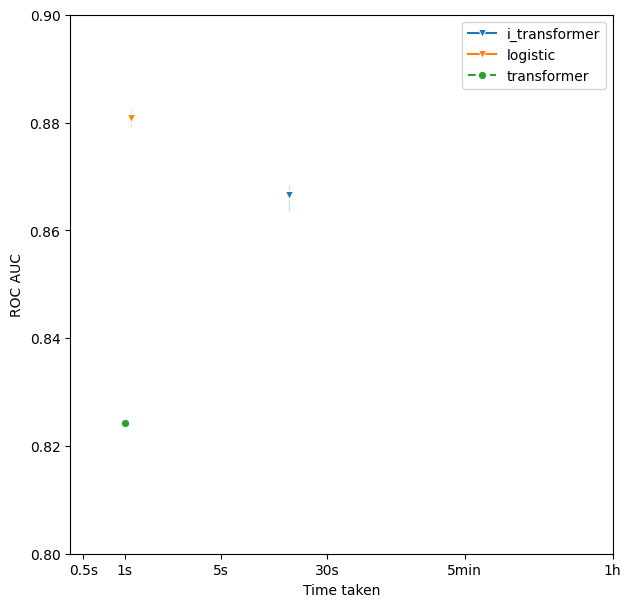

In [136]:
exclude=['']
#ax = make_tabular_results_plot('time', exclude=exclude)
ax = make_tabular_results_plot('roc', df_=df_absolute, exclude=exclude, grouping=False, max_times=[0.5, 1, 5, 30, 60*5, 60*60])
# ax.set_ylim([0.84, 0.9])
ax.set_ylim([0.8, 0.9])
ax.set_xlim([np.log10(0.4), np.log10(3600)])
# ax.legend([],[], frameon=False)

#tikzplotlib.save(f'roc_over_time.tex', axis_height='5cm', axis_width='6cm', strict=True)

/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


methods ['transformer', 'logistic']
method logistic
df_method Empty DataFrame
Columns: [metricroc, real_time, time, method, split_number, metricrank_roc, metricwins_roc, metriccross_entropy, metricrank_cross_entropy, metricwins_cross_entropy, metrictime, metricrank_time, metricwins_time, time_log, real_time_log]
Index: []
df_trans 1 Empty DataFrame
Columns: [metricroc, real_time, time, method, split_number, metricrank_roc, metricwins_roc, metriccross_entropy, metricrank_cross_entropy, metricwins_cross_entropy, metrictime, metricrank_time, metricwins_time, time_log, real_time_log]
Index: []
time_column time_log
df_trans 2 Empty DataFrame
Columns: [metricroc, real_time, time, method, split_number, metricrank_roc, metricwins_roc, metriccross_entropy, metricrank_cross_entropy, metricwins_cross_entropy, metrictime, metricrank_time, metricwins_time, time_log, real_time_log]
Index: []


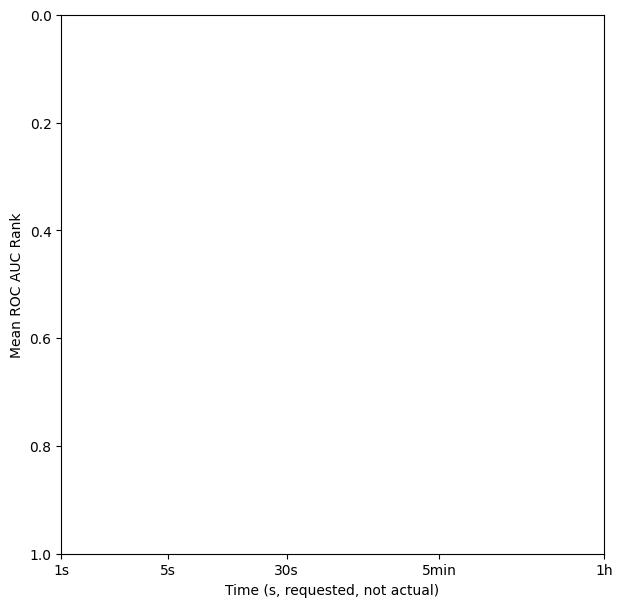

In [35]:
ax = make_tabular_results_plot('rank_roc', df_=df_[df_.time >= 1].copy(), exclude=['tabnet'], max_times=[1, 5, 30, 60*5, 60*60])
ax.invert_yaxis()
ax.set_xlim([np.log10(1.0), np.log10(3600)])
ax.legend([],[], frameon=False)
# tikzplotlib.save(f'roc_raks_tabular.tex', axis_height='5cm', axis_width='6cm', strict=True)

/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


methods ['transformer', 'logistic']
method logistic
df_method Empty DataFrame
Columns: [metricroc, real_time, time, method, split_number, metricrank_roc, metricwins_roc, metriccross_entropy, metricrank_cross_entropy, metricwins_cross_entropy, metrictime, metricrank_time, metricwins_time, time_log, real_time_log]
Index: []
df_trans 1 Empty DataFrame
Columns: [metricroc, real_time, time, method, split_number, metricrank_roc, metricwins_roc, metriccross_entropy, metricrank_cross_entropy, metricwins_cross_entropy, metrictime, metricrank_time, metricwins_time, time_log, real_time_log]
Index: []
time_column time_log
df_trans 2 Empty DataFrame
Columns: [metricroc, real_time, time, method, split_number, metricrank_roc, metricwins_roc, metriccross_entropy, metricrank_cross_entropy, metricwins_cross_entropy, metrictime, metricrank_time, metricwins_time, time_log, real_time_log]
Index: []


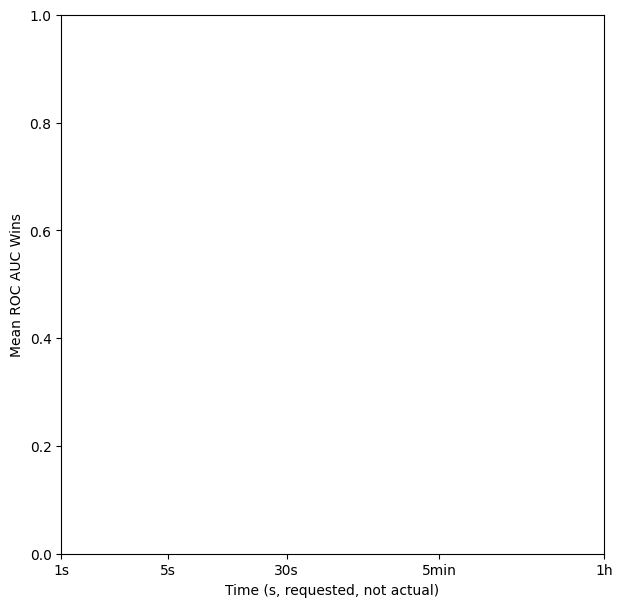

In [36]:
ax = make_tabular_results_plot('wins_roc', df_=df_[df_.time >= 1].copy(), exclude=exclude, max_times=[1, 5, 30, 60*5, 60*60])
ax.set_xlim([np.log10(1.0), np.log10(3600)])
ax.legend([],[], frameon=False)
# tikzplotlib.save(f'roc_wins_tabular.tex', axis_height='5cm', axis_width='6cm', strict=True)

#### Big Table metrics

In [ ]:
# ADDED BY UGNE

# %%script echo skipping

pos = str(eval_positions[0])

global_results = {}
overwrite=False

# print(methods)
# print(max_times)
# print(range(1,5+1))

methods = ['i_transformer','transformer','logistic']

# for method in baseline_methods:
for method in methods:
    for max_time in max_times:
        for split_number in range(1,5+1):
            global_results[method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)] = eval_method(task_type, method,  None, selector, 
                                                                                                                                    eval_positions, fetch_only=True, 
                                                                                                                                    verbose=False, max_time=max_time,
                                                                                                                                    metric_used=metric_used, split_number=split_number)

In [ ]:
# ADDED BY UGNE

limit_to = ''
calculate_score(tabular_metrics.auc_metric, 'roc', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.cross_entropy, 'cross_entropy', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.accuracy_metric, 'acc', global_results, test_datasets, eval_positions + [-1])
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='mean', limit_to=limit_to)
calculate_score(tabular_metrics.count_metric, 'count', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)

In [152]:
max_time = '3600'

In [160]:
global_results_filtered = {**global_results}
global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k or 'transformer' in k}


/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
global_results_filtered

{'i_transformer_time_0.5roc_auc_split_1': {'metric_used': 'roc_auc_ovo',
  'bptt': 2000,
  'eval_positions': [1000],
  'balance-scale_best_configs_at_1000': [None],
  'balance-scale_outputs_at_1000': array([[[3.16051453e-01, 4.53955829e-01, 2.29992732e-01],
          [7.05876155e-03, 1.82363763e-02, 9.74704802e-01],
          [4.07515017e-06, 1.59276533e-04, 9.99836564e-01],
          [9.99818265e-01, 1.65387290e-04, 1.63226559e-05],
          [9.43609655e-01, 4.32103537e-02, 1.31799905e-02],
          [1.56678099e-04, 3.74951004e-03, 9.96093810e-01],
          [9.99879837e-01, 1.02683036e-04, 1.75754249e-05],
          [5.59551017e-06, 1.10869165e-04, 9.99883533e-01],
          [9.99953866e-01, 4.19183962e-05, 4.17297952e-06],
          [9.99879122e-01, 1.09260422e-04, 1.15785024e-05],
          [3.93180471e-06, 4.16640250e-05, 9.99954343e-01],
          [1.77530630e-04, 5.80091355e-03, 9.94021595e-01],
          [1.96549058e-01, 2.45792136e-01, 5.57658792e-01],
          [1.68075292e

In [161]:
# roc_matrix, roc_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'roc', test_datasets_multiclass_filtered)
# acc_matrix, acc_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'acc', test_datasets_multiclass_filtered)
# cross_entropy_matrix, cross_entropy_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'cross_entropy', test_datasets_multiclass_filtered)
# time_matrix, time_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets_multiclass_filtered)

roc_matrix, roc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'roc', test_datasets)
print(f">> we do acc")
acc_matrix, acc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'acc', test_datasets)
cross_entropy_matrix, cross_entropy_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'cross_entropy', test_datasets)
time_matrix, time_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)

roc_rank, roc_wins = make_ranks_and_wins_table(roc_matrix.copy())
acc_rank, acc_wins = make_ranks_and_wins_table(acc_matrix.copy())
cross_entropy_rank, cross_entropy_wins = make_ranks_and_wins_table(-cross_entropy_matrix.copy())

result.shape (30, 15)
>> we do acc
result.shape (30, 15)
result.shape (30, 15)
result.shape (30, 15)


In [168]:
acc_matrix

i_transformer  transformer  logistic
balance-scale                          0.905769     0.879487  0.890385
mfeat-fourier                          0.554600     0.189200  0.800200
breast-w                               0.968481     0.972493  0.951289
mfeat-karhunen                         0.692000     0.341200  0.948200
mfeat-morphological                    0.680200     0.427200  0.737600
mfeat-zernike                          0.569000     0.319400  0.807000
cmc                                    0.523370     0.514130  0.490217
credit-approval                        0.855072     0.842899  0.851594
credit-g                               0.758800     0.741200  0.740800
diabetes                               0.774479     0.764062  0.780208
tic-tac-toe                            0.650939     0.734864  0.980793
vehicle                                0.689362     0.613239  0.785816
eucalyptus                             0.608696     0.517391  0.602174
analcatdata_authorship                 0.984762     0.915238  0.997143
analcatdata_dmft                       0.210050     0.195477  0.209045
pc4                                    0.890535     0.873251  0.898491
pc3                                    0.902433     0.901152  0.900384
kc2                                    0.822989     0.819923  0.819157
pc1                                    0.926715     0.927437  0.927798
banknote-authentication                0.993294     0.949271  0.986297
blood-transfusion-service-center       0.768449     0.786096  0.764706
ilpd                                   0.690722     0.680412  0.704467
qsar-biodeg                            0.863378     0.809488  0.867173
wdbc                                   0.972535     0.939437  0.964085
cylinder-bands                         0.714815     0.694815  0.748889
dresses-sales                          0.560800     0.545600  0.601600
MiceProtein                            0.730370     0.311111  0.940000
car                                    0.894444     0.844213  0.928704
steel-plates-fault                     0.700412     0.557526  0.706598
climate-model-simulation-crashes       0.932593     0.917778  0.948148

In [166]:
print(roc_wins)
print(roc_rank)

i_transformer    10
transformer       1
logistic         16
dtype: int64
i_transformer    1.716667
transformer      2.766667
logistic         1.516667
dtype: float64


/Users/Ugne/opt/anaconda3/envs/DL_project/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [167]:
print(acc_wins)
print(acc_rank)

i_transformer    10
transformer       2
logistic         18
dtype: int64
i_transformer    1.716667
transformer      2.700000
logistic         1.583333
dtype: float64


In [84]:
def wins_vs_idx(matrix, idx):
    wins_auc = np.array([[(matrix.values[:, j] < matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    ties_auc = np.array([[(matrix.values[:, j] == matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    losses_auc = np.array([[(matrix.values[:, j] > matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    
    return wins_auc, ties_auc, losses_auc

transformer_idx = np.where(roc_matrix.columns == 'transformer')[0][0]

wins_roc_vs_us, ties_roc_vs_us, losses_roc_vs_us = wins_vs_idx(roc_matrix, transformer_idx)
wins_acc_vs_us, ties_acc_vs_us, losses_acc_vs_us = wins_vs_idx(acc_matrix, transformer_idx)
wins_ce_vs_us, ties_ce_vs_us, losses_ce_vs_us = wins_vs_idx(-cross_entropy_matrix, transformer_idx)

In [85]:
def rename(table):
    return table.rename(columns=relabeler).T.rename(columns={'blood-transfusion-service-center': 'blood-transfus..'
                                                                , 'jungle_chess_2pcs_raw_endgame_complete': 'jungle\_chess..', 'bank-marketing': 'bank-market..'}).T

def get_suffix(i, k):
    suffix = ''
    suffix = suffix+'s' if test_datasets[i][5]['samples_capped'] == True else suffix
    suffix = suffix+'f' if test_datasets[i][5]['feats_capped'] == True else suffix
    suffix = suffix+'c' if test_datasets[i][5]['classes_capped'] == True else suffix
    suffix = '' if len(suffix) == 0 else f' [{suffix}]'
    
    return k + suffix

In [86]:
relabeler = {'transformer': 'Tabular PFN'
             , 'autogluon': 'Autogluon'
             , 'autosklearn2': 'Autosklearn2'
             , 'gp': 'GP (RBF)'
             , 'logistic': 'Log. Regr.'
             , 'knn': 'KNN'
             , 'catboost': 'Catboost'
            , 'xgb': 'XGB'}

In [87]:
table = roc_matrix.copy()
#table = roc_ovr_matrix.copy()
#table = acc_matrix.copy()
#table = cross_entropy_matrix.copy()

#table = table_acc
table.index = [get_suffix(i, k) for i, k in enumerate(table.index[0:table.shape[0]])]

table.loc['Wins AUC OVO'] = rocs_wins.values
#table.loc['Mean AUC OVR'] = roc_ovr_matrix.mean(skipna=True)
table.loc['Wins Acc.'] = acc_wins.values
#table.loc['Mean Bal. Acc.'] = balanced_acc_matrix.mean()
table.loc['Wins CE'] = cross_entropy_wins.values

table.loc['Win/T/L AUC vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_roc_vs_us[-1, :], ties_roc_vs_us[-1, :], losses_roc_vs_us[-1, :])]
table.loc['Win/T/L Acc vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_acc_vs_us[-1, :], ties_acc_vs_us[-1, :], losses_acc_vs_us[-1, :])]
table.loc['Win/T/L CE vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_ce_vs_us[-1, :], ties_ce_vs_us[-1, :], losses_ce_vs_us[-1, :])]

table.loc['Mean AUC OVO'] = roc_matrix.mean(skipna=True)
table.loc['Mean AUC OVO Stds'] = roc_matrix_stds.mean(skipna=True)

#table.loc['Mean AUC OVR'] = roc_ovr_matrix.mean(skipna=True)
table.loc['Mean Acc.'] = acc_matrix.mean()
table.loc['Mean Acc. Stds'] = acc_matrix_stds.mean(skipna=True)

#table.loc['Mean Bal. Acc.'] = balanced_acc_matrix.mean()
table.loc['Mean CE'] = cross_entropy_matrix.mean()
table.loc['Mean CE Stds'] = cross_entropy_matrix_stds.mean()

table.loc['M. rank AUC OVO'] = roc_rank.values
#table.loc['Mean rank AUC OVR'] = roc_ovr_rank.values
table.loc['Mean rank Acc.'] = acc_rank.values
#table.loc['Mean rank Bal. Acc.'] = balanced_acc_rank.values
table.loc['Mean rank CE'] = cross_entropy_rank.values

table.loc['Mean time (s)'] = time_matrix.mean()
table.loc['Mean time (s)', 'knn'] = 0.5
table.loc['Mean time (s)', 'logistic'] = 60

# table = table[['knn', 'logistic', 'gp', 'catboost', 'xgb', 'autosklearn2', 'autogluon', 'transformer']]
table = table[['logistic', 'transformer']]
rename(table).round(decimals=3).style.highlight_max(axis = 1, props= 'font-weight: bold;').format(precision=3)

In [88]:
def bold_extreme_values(data, format_string="%.3g", max_=True):
    data = data.astype(float).round(3)
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

def to_str(data, format_string="%.3g"):
    formatted = data.apply(lambda x : format_string % x)
    return formatted

In [89]:
keys_max = ["Mean rank CE", "Mean rank Acc.", "Mean rank AUC OVO", "Mean rank AUC OVR", "Mean rank Bal. Acc.", "Mean AUC OVO", "Mean Acc."]
keys_max = ["Mean AUC OVO", "Mean Acc.", "Wins AUC OVO", "Wins Acc.", "Wins CE"]

keys_min = ["Mean rank CE", "Mean rank Acc.", "M. rank AUC OVO", "Mean CE"]

table_latex = rename(table).copy()

table_latex.iloc[0:30] = table_latex.iloc[0:30].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[["Mean time (s)"]] = table_latex.loc[["Mean time (s)"]].apply(lambda data : bold_extreme_values(data, format_string="%.4g", max_=False), axis=1)
table_latex.loc[keys_max] = table_latex.loc[keys_max].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[keys_min] = table_latex.loc[keys_min].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex.loc[['Mean CE Stds']] = table_latex.loc[['Mean CE Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean CE'] = table_latex.loc['Mean CE'] + '$\pm$' + table_latex.loc['Mean CE Stds']
table_latex = table_latex.drop(['Mean CE Stds'])

table_latex.loc[['Mean Acc. Stds']] = table_latex.loc[['Mean Acc. Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean Acc.'] = table_latex.loc['Mean Acc.'] + '$\pm$' + table_latex.loc['Mean Acc. Stds']
table_latex = table_latex.drop(['Mean Acc. Stds'])

table_latex.loc[['Mean AUC OVO Stds']] = table_latex.loc[['Mean AUC OVO Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean AUC OVO'] = table_latex.loc['Mean AUC OVO'] + '$\pm$' + table_latex.loc['Mean AUC OVO Stds']
table_latex = table_latex.drop(['Mean AUC OVO Stds'])

table_latex
# print(table_latex.to_latex(escape=False))

Log. Regr.      Tabular PFN
balance-scale                               \textbf{0.959}             0.92
mfeat-fourier                               \textbf{0.973}            0.736
breast-w                                    \textbf{0.994}            0.986
mfeat-karhunen                              \textbf{0.995}            0.831
mfeat-morphological                         \textbf{0.963}            0.882
mfeat-zernike                               \textbf{0.979}             0.77
cmc                                                  0.684   \textbf{0.694}
credit-approval                             \textbf{0.915}            0.912
credit-g                                             0.763   \textbf{0.772}
diabetes                                     \textbf{0.84}             0.83
tic-tac-toe                                 \textbf{0.995}            0.817
vehicle                                     \textbf{0.944}            0.875
eucalyptus                                  \textbf{0.868}            0.829
analcatdata_authorship                          \textbf{1}            0.993
analcatdata_dmft                            \textbf{0.567}            0.563
pc4                                         \textbf{0.894}            0.845
pc3                                                  0.782   \textbf{0.805}
kc2                                                  0.829   \textbf{0.836}
pc1                                         \textbf{0.819}            0.807
banknote-authentication                         \textbf{1}            0.996
blood-transfus..                            \textbf{0.749}            0.748
ilpd                                         \textbf{0.74}            0.714
qsar-biodeg                                 \textbf{0.922}            0.882
wdbc                                        \textbf{0.994}            0.986
cylinder-bands                              \textbf{0.835}            0.757
dresses-sales                                \textbf{0.58}            0.539
MiceProtein                                 \textbf{0.995}             0.82
car                                         \textbf{0.981}            0.862
steel-plates-fault                          \textbf{0.934}            0.859
climate-model-simulation-crashes            \textbf{0.931}            0.862
Wins AUC OVO                                             0      \textbf{30}
Wins Acc.                                      \textbf{24}                5
Wins CE                                        \textbf{22}                7
Win/T/L AUC vs Us                                   26/0/4            0/0/0
Win/T/L Acc vs Us                                   24/0/6            0/0/0
Win/T/L CE vs Us                                    23/0/7            0/0/0
Mean AUC OVO                      \textbf{0.881}$\pm$0.012  0.824$\pm$0.014
Mean Acc.                         \textbf{0.809}$\pm$0.015  0.684$\pm$0.014
Mean CE                           \textbf{0.773}$\pm$0.044  0.911$\pm$0.014
M. rank AUC OVO                              \textbf{1.13}             1.87
Mean rank Acc.                               \textbf{1.18}             1.82
Mean rank CE                                 \textbf{1.25}             1.75
Mean time (s)                                           60   \textbf{7.824}

In [46]:
print(table_latex.to_latex(escape=False))

NameError: name 'table_latex' is not defined

In [47]:
table_latex_small = table_latex.iloc[-len(keys_min+keys_max)-1-3:]
table_latex_small

NameError: name 'table_latex' is not defined

In [48]:
print(table_latex_small.to_latex(escape=False))

NameError: name 'table_latex_small' is not defined

In [49]:
table_latex = table.copy()

table_latex.iloc[:-5] = table_latex.iloc[:-5].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.iloc[-5:-5] = table_latex.iloc[-5:-5].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex
#print(table_latex.to_latex(escape=False))

ValueError: could not convert string to float: '0/0/0'

In [50]:
rename(table[-7:]).round(decimals=3).style.highlight_min(axis = 1, props= 'font-weight: bold;').format(precision=3)